<a href="https://colab.research.google.com/github/hima111997/Arabic-Hand-Written-recognition-/blob/master/arabic_hand_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arabic Hand-Written Recognition using Keras

  * methods:
    
    * data was downloaded from Kaggle: https://www.kaggle.com/mloey1/ahcd1 using Kaggle API, extracted, and pixels were converted from dataframe into images
    * A CNN Model was created using Keras
    * Data Augmentation was used using ImageDataGenerator from keras
    * training was started with two different optimizers: Adam and SGD for 1000 and 900 epochs, respectively.
    * after finishing training, model was tested on the test data achieving 97.97% accuracy.

# Downloading data

In [0]:
!mkdir /root/.kaggle
!mkdir /content/.kaggle
import json
token = {'username':'XXXXXXXXX','key':'XXXXXXXXXXXXXXXXXXXXXXXXXXX'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json    
!ls  /root/.kaggle
!kaggle config set -n path -v/content



kaggle.json
- path is now set to: /content


In [0]:
!kaggle datasets download -d mloey1/ahcd1

 79% 19.0M/24.0M [00:00<00:00, 20.2MB/s]
100% 24.0M/24.0M [00:00<00:00, 30.9MB/s]


# extracting data

In [0]:
import shutil
import zipfile, os
# with zipfile.ZipFile('/content/datasets/mloey1/ahcd1/ahcd1.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/hand_written')
with zipfile.ZipFile('/content/handwritten_SGD_V9.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/handwritten_SGD_V9')    

# converting from dataframe to .png files

In [0]:
import pandas as pd

test_x = pd.read_csv('/content/hand_written/arabic handwritten characters dataset csv/csvTestImages 3360x1024.csv')
test_labels = pd.read_csv('/content/hand_written/csvTestLabel 3360x1.csv')

train_x = pd.read_csv('/content/hand_written/arabic handwritten characters dataset csv/csvTrainImages 13440x1024.csv')
train_labels = pd.read_csv('/content/hand_written/csvTrainLabel 13440x1.csv')

In [0]:
train_x.describe()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.866,0.867,0.868,0.869,0.870,0.871,0.872,0.873,0.874,0.875,0.876,0.877,0.878,0.879,0.880,0.881,0.882,0.883,0.884,0.885,0.886,0.887,0.888,0.889,0.890,0.891,0.892,0.893,0.894,0.895,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
count,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,...,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000,13439.000000
mean,0.121586,0.021356,0.009748,0.011310,0.019049,0.005358,0.005060,0.020909,0.033336,0.042712,0.093831,0.129846,0.167126,0.201280,0.259766,0.336855,0.441923,0.540814,0.554357,0.584567,0.547362,0.417739,0.240420,0.217576,0.205224,0.183942,0.137510,0.112955,0.052087,0.054692,0.061463,0.229109,0.041893,0.012203,0.007441,0.021281,0.013394,0.002307,0.005953,0.009748,...,0.247042,0.317658,0.365131,0.304040,0.228365,0.110648,0.103579,0.262147,0.482328,0.217725,0.145770,0.138775,0.126870,0.118312,0.091153,0.066151,0.061612,0.072922,0.115410,0.151871,0.192425,0.270481,0.306942,0.339460,0.486197,0.649081,0.580326,0.502716,0.418409,0.389761,0.302478,0.221147,0.240792,0.295111,0.373540,0.355086,0.293102,0.242131,0.306198,0.931096
std,2.832441,0.956054,0.699952,0.826084,2.199682,0.621082,0.552609,1.438761,2.336339,2.397652,3.909307,4.980632,5.618421,6.149454,6.226227,7.837130,9.010463,10.231046,10.316916,10.683445,10.230960,8.727092,6.130072,6.074584,5.732295,5.424194,4.696218,4.291650,2.313815,3.002836,2.669931,3.978581,1.262692,1.174783,0.674700,1.582384,1.216777,0.179904,0.664715,0.660458,...,5.853840,6.728291,8.105924,7.150029,6.249323,4.145645,4.092688,5.564833,5.277798,3.703164,2.829288,2.956048,2.763468,2.551623,2.190159,1.857520,2.115630,1.917454,3.849973,5.120683,5.648945,6.883429,7.100489,7.076114,9.137020,10.699376,9.761263,9.105636,8.351966,7.564764,6.420739,4.900747,5.456882,5.841303,7.395312,7.146457,5.845893,4.902245,5.348775,8.753849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

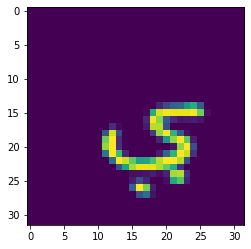

In [0]:
plt.imshow(test_x.iloc[3358].values.reshape(32,32).T)

In [0]:
import os

os.mkdir('/content/datasets/train')
for i in range(1,29):
  os.mkdir('/content/datasets/train/{}'.format(i))

os.mkdir('/content/datasets/test')
for i in range(1,29):
  os.mkdir('/content/datasets/test/{}'.format(i))



In [0]:
# PREPAIRING FILES
import numpy as np
from tensorflow.keras.preprocessing import image

def prepairing_files(df_x, df_labels, train = True):
  if train:
    path = '/content/datasets/train/' 
  else:
    path = '/content/datasets/test/'
  for idx,vect in df_x.iterrows():
    label = df_labels.iloc[idx].values[0]   
    image.save_img(path + '{}/{}.png'.format(label,idx),
                  np.expand_dims(vect.values.reshape(32,32).T, axis = 2)
                  )
    

prepairing_files(train_x, train_labels)
prepairing_files(test_x, test_labels, False)


# Creating model

In [0]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

inputs = Input(shape = (32,32,3))

X = layers.Conv2D(64, (7,7), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(inputs) #32
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 15

X = layers.Conv2D(128, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 15
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) #7

X = layers.Conv2D(256, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 7
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 3

X = layers.GlobalAveragePooling2D()(X) # 256

X = layers.Dense(500, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(250, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(125, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(28, activation = 'softmax')(X)



log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = inputs, outputs = X)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512   

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255., 
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3],
                               width_shift_range = .5,
                               height_shift_range = .25,
                               shear_range = .3,
                               fill_mode = 'constant',
                               cval = 0,
                               validation_split = .2
                               )

valid_gen = ImageDataGenerator(rescale = 1/255., 
                               validation_split = .2)

train_generator = train_gen.flow_from_directory('/content/datasets/train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='training')

valid_generator = valid_gen.flow_from_directory('/content/datasets/train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='validation')

Using TensorFlow backend.


Found 10752 images belonging to 28 classes.
Found 2687 images belonging to 28 classes.


In [0]:
optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy', # classes as integers
              metrics=['accuracy',
                       Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

# training for 1000 epochs (10 means 1000)

In [0]:
model.fit(train_generator,
                    epochs = 100,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback]) # , call

In [0]:
model.save('handwrittenV1')

In [0]:
!zip -r /content/handwrittenV1.zip /content/handwrittenV1
from google.colab import files
files.download("/content/handwrittenV1.zip")

In [0]:
model.fit(train_generator,
                    epochs = 100,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback]) # , call

In [0]:
model.save('handwrittenV2')
!zip -r /content/handwrittenV2.zip /content/handwrittenV2
from google.colab import files
files.download("/content/handwrittenV2.zip")

In [0]:
model.fit(train_generator,
                    epochs = 100,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback]) # , call

In [0]:
model.save('handwrittenV3')

In [0]:
!zip -r /content/handwrittenV3.zip /content/handwrittenV3
from google.colab import files
files.download("/content/handwrittenV3.zip") # accuracy: 0.8199 / val_accuracy: 0.9237 at epoch 300

In [0]:
from tensorflow.keras.models import load_model
model = load_model('handwrittenV3')

In [0]:
log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/handwrittenV3_continue"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [0]:
optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy', # classes as integers
              metrics=['accuracy',
                       Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

In [0]:
model.fit(train_generator,
                    epochs = 100,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback]) # , call

In [0]:
model.save('handwrittenV4')

In [0]:
!zip -r /content/handwrittenV4.zip /content/handwrittenV4
from google.colab import files
files.download("/content/handwrittenV4.zip") # accuracy: 0.8510 / val_accuracy: 0.9390 at epoch 400

In [0]:
model.fit(train_generator,
                    epochs = 100,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback]) # , call

In [0]:
model.save('handwrittenV5')
!zip -r /content/handwrittenV5.zip /content/handwrittenV5
from google.colab import files
files.download("/content/handwrittenV5.zip")

INFO:tensorflow:Assets written to: handwrittenV5/assets
  adding: content/handwrittenV5/ (stored 0%)
  adding: content/handwrittenV5/variables/ (stored 0%)
  adding: content/handwrittenV5/variables/variables.data-00001-of-00002 (deflated 19%)
  adding: content/handwrittenV5/variables/variables.data-00000-of-00002 (deflated 82%)
  adding: content/handwrittenV5/variables/variables.index (deflated 72%)
  adding: content/handwrittenV5/saved_model.pb (deflated 90%)
  adding: content/handwrittenV5/assets/ (stored 0%)


In [0]:
model.fit(train_generator,
                    epochs = 100,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback]) # , call  accuracy: 0.8600   val_accuracy: 0.9501

In [0]:
model.fit(train_generator,
                    epochs = 400,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback]) # , call

Epoch 1/400
336/336 [==============================] - 11s 33ms/step - loss: 0.4967 - accuracy: 0.8638 - recall: 0.8275 - precision: 0.9300 - auc: 0.9911 - auc_1: 0.9313 - val_loss: 0.3607 - val_accuracy: 0.9494 - val_recall: 0.9438 - val_precision: 0.9545 - val_auc: 0.9910 - val_auc_1: 0.9645
Epoch 2/400
336/336 [==============================] - 11s 33ms/step - loss: 0.5033 - accuracy: 0.8614 - recall: 0.8235 - precision: 0.9291 - auc: 0.9910 - auc_1: 0.9315 - val_loss: 0.3560 - val_accuracy: 0.9472 - val_recall: 0.9442 - val_precision: 0.9530 - val_auc: 0.9892 - val_auc_1: 0.9611
Epoch 3/400
336/336 [==============================] - 11s 33ms/step - loss: 0.5064 - accuracy: 0.8622 - recall: 0.8263 - precision: 0.9254 - auc: 0.9904 - auc_1: 0.9297 - val_loss: 0.3172 - val_accuracy: 0.9546 - val_recall: 0.9527 - val_precision: 0.9613 - val_auc: 0.9932 - val_auc_1: 0.9725
Epoch 4/400
336/336 [==============================] - 11s 32ms/step - loss: 0.4850 - accuracy: 0.8633 - recall: 0.

In [0]:
model.save('handwrittenV10') # accuracy: 0.8735   val_accuracy: 0.9576  at epoch 1000
!zip -r /content/handwrittenV10.zip /content/handwrittenV10
from google.colab import files
files.download("/content/handwrittenV10.zip")

## Testing 

In [0]:
with zipfile.ZipFile('/content/handwrittenV10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/handwrittenV10')   

from tensorflow.keras.models import load_model
model = load_model('/content/handwrittenV10/content/handwrittenV10')      

In [0]:
from keras.preprocessing.image import ImageDataGenerator
test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = test_gen.flow_from_directory('/content/datasets/test',
                                                 target_size=(32, 32),
                                                 batch_size=1,
                                                  shuffle=False,
                                                 class_mode = 'categorical'
                                                 )


Using TensorFlow backend.


Found 3359 images belonging to 28 classes.


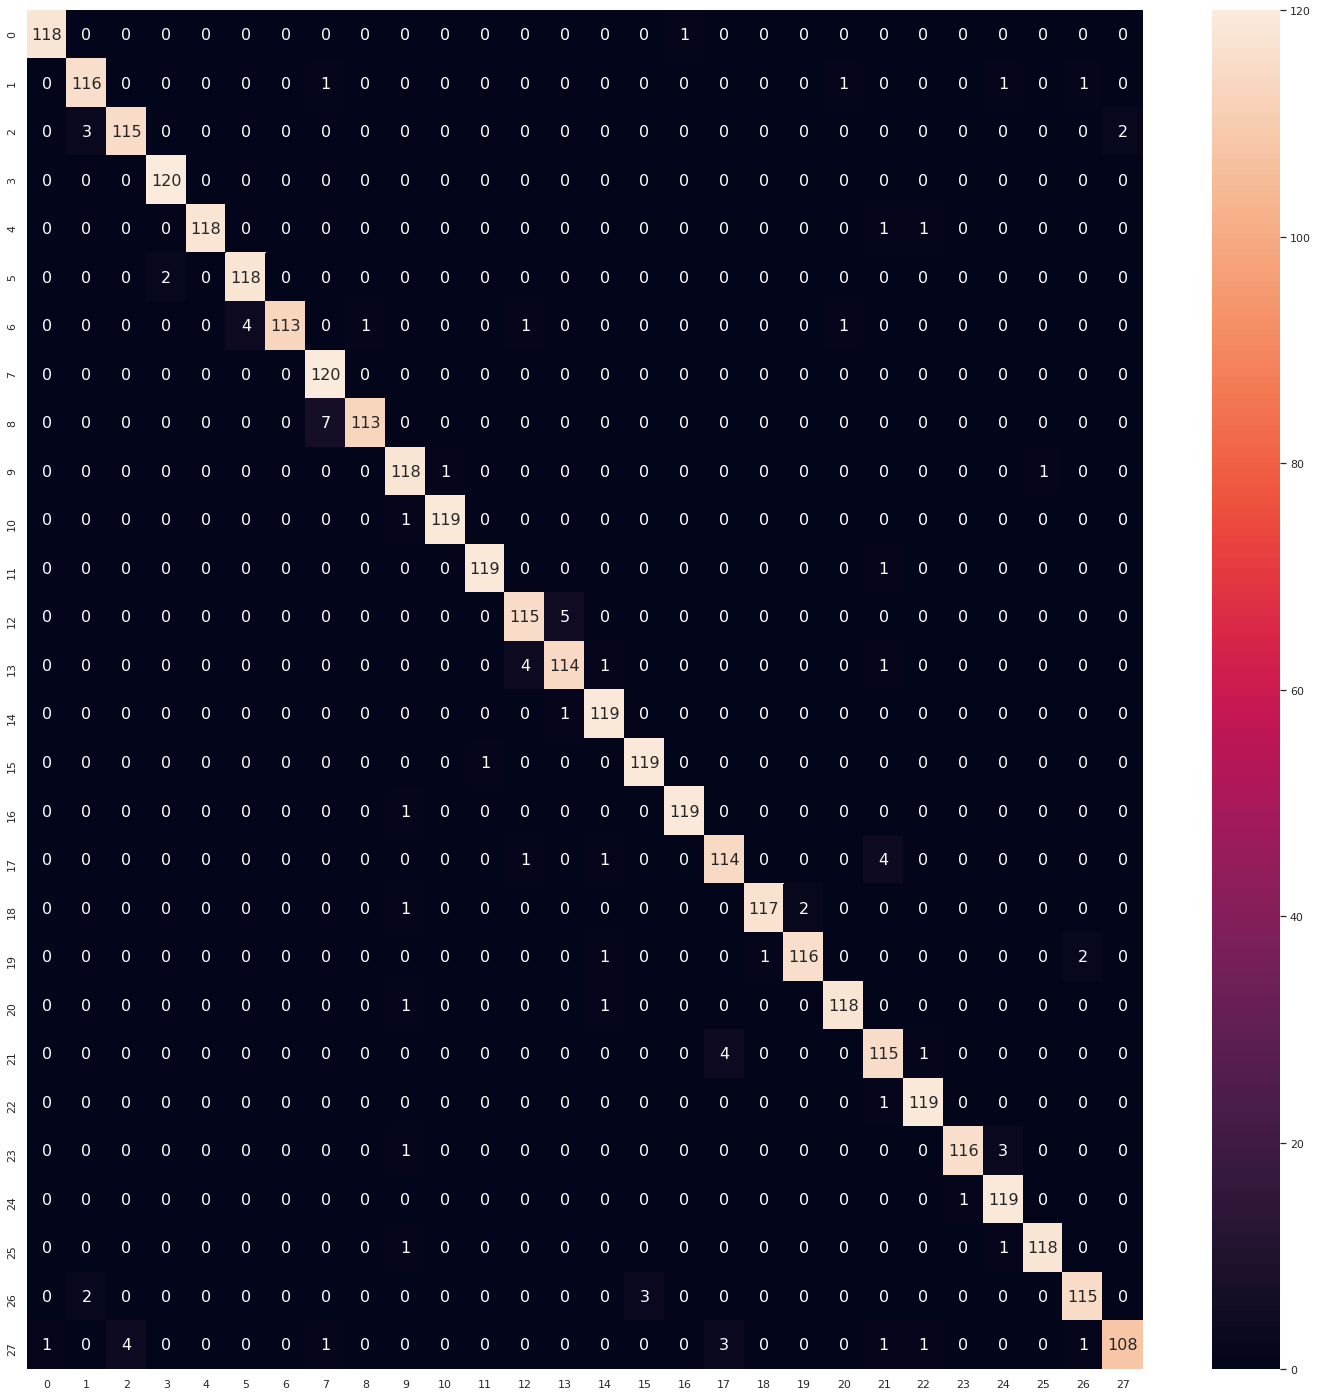

<Figure size 1080x1080 with 0 Axes>

,Precision,Recall,F1_score
0,0.991597,0.991597,0.991597
1,0.958678,0.966667,0.962656
2,0.966387,0.958333,0.962343
3,0.983607,1.000000,0.991736
4,1.000000,0.983333,0.991597
5,0.967213,0.983333,0.975207
6,1.000000,0.941667,0.969957
7,0.930233,1.000000,0.963855
8,0.991228,0.941667,0.965812
9,0.951613,0.983333,0.967213


In [0]:
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.math import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities.argmax(axis=1)

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(28), range(28))
sn.set(font_scale=1.4) # for label size
sn.set(rc={'figure.figsize':(25,25)})
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt= 'd') # font size
plt.figure(figsize = (15,15))
plt.show()

precision, recall, f1, _ = score(y_true, y_pred)
pd.DataFrame([precision, recall, f1] , index = ['Precision', 'Recall', 'F1_score']).T
# 97.27% accuracy on test

In [0]:
mat.diagonal().sum()/3359

0.9729086037511164

# trying another optimizer

In [0]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

inputs = Input(shape = (32,32,3))


X = layers.Conv2D(64, (7,7), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(inputs) #32
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 15

X = layers.Conv2D(128, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 15
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) #7

X = layers.Conv2D(256, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 7
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 3

X = layers.GlobalAveragePooling2D()(X) # 256

X = layers.Dense(500, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(250, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(125, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(28, activation = 'softmax')(X)



log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = inputs, outputs = X)
model.summary()


In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255., 
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3],
                               width_shift_range = .5,
                               height_shift_range = .25,
                               shear_range = .3,
                               fill_mode = 'constant',
                               cval = 0,
                               validation_split = .2
                               )

valid_gen = ImageDataGenerator(rescale = 1/255., 
                               validation_split = .2)

train_generator = train_gen.flow_from_directory('/content/datasets/train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='training')

valid_generator = valid_gen.flow_from_directory('/content/datasets/train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='validation')


In [0]:
optim = optimizers.SGD(lr = .01, momentum=.09)
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy', # classes as integers
              metrics=['accuracy',
                       Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

## training for 900 epochs (9 means 900)

In [0]:
model.fit(train_generator,
                    epochs = 900,
                    validation_data = valid_generator,
                    steps_per_epoch = 336,
                    validation_steps = 84,
                    callbacks=[tensorboard_callback])

In [0]:
model.save('handwritten_SGD_V9')
!zip -r /content/handwritten_SGD_V9.zip /content/handwritten_SGD_V9
from google.colab import files
files.download("/content/handwritten_SGD_V9.zip")

INFO:tensorflow:Assets written to: handwritten_SGD_V9/assets
  adding: content/handwritten_SGD_V9/ (stored 0%)
  adding: content/handwritten_SGD_V9/saved_model.pb (deflated 90%)
  adding: content/handwritten_SGD_V9/assets/ (stored 0%)
  adding: content/handwritten_SGD_V9/variables/ (stored 0%)
  adding: content/handwritten_SGD_V9/variables/variables.data-00001-of-00002 (deflated 10%)
  adding: content/handwritten_SGD_V9/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: content/handwritten_SGD_V9/variables/variables.index (deflated 72%)


## Testing

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/handwritten_SGD_V9/content/handwritten_SGD_V9')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Found 3359 images belonging to 28 classes.


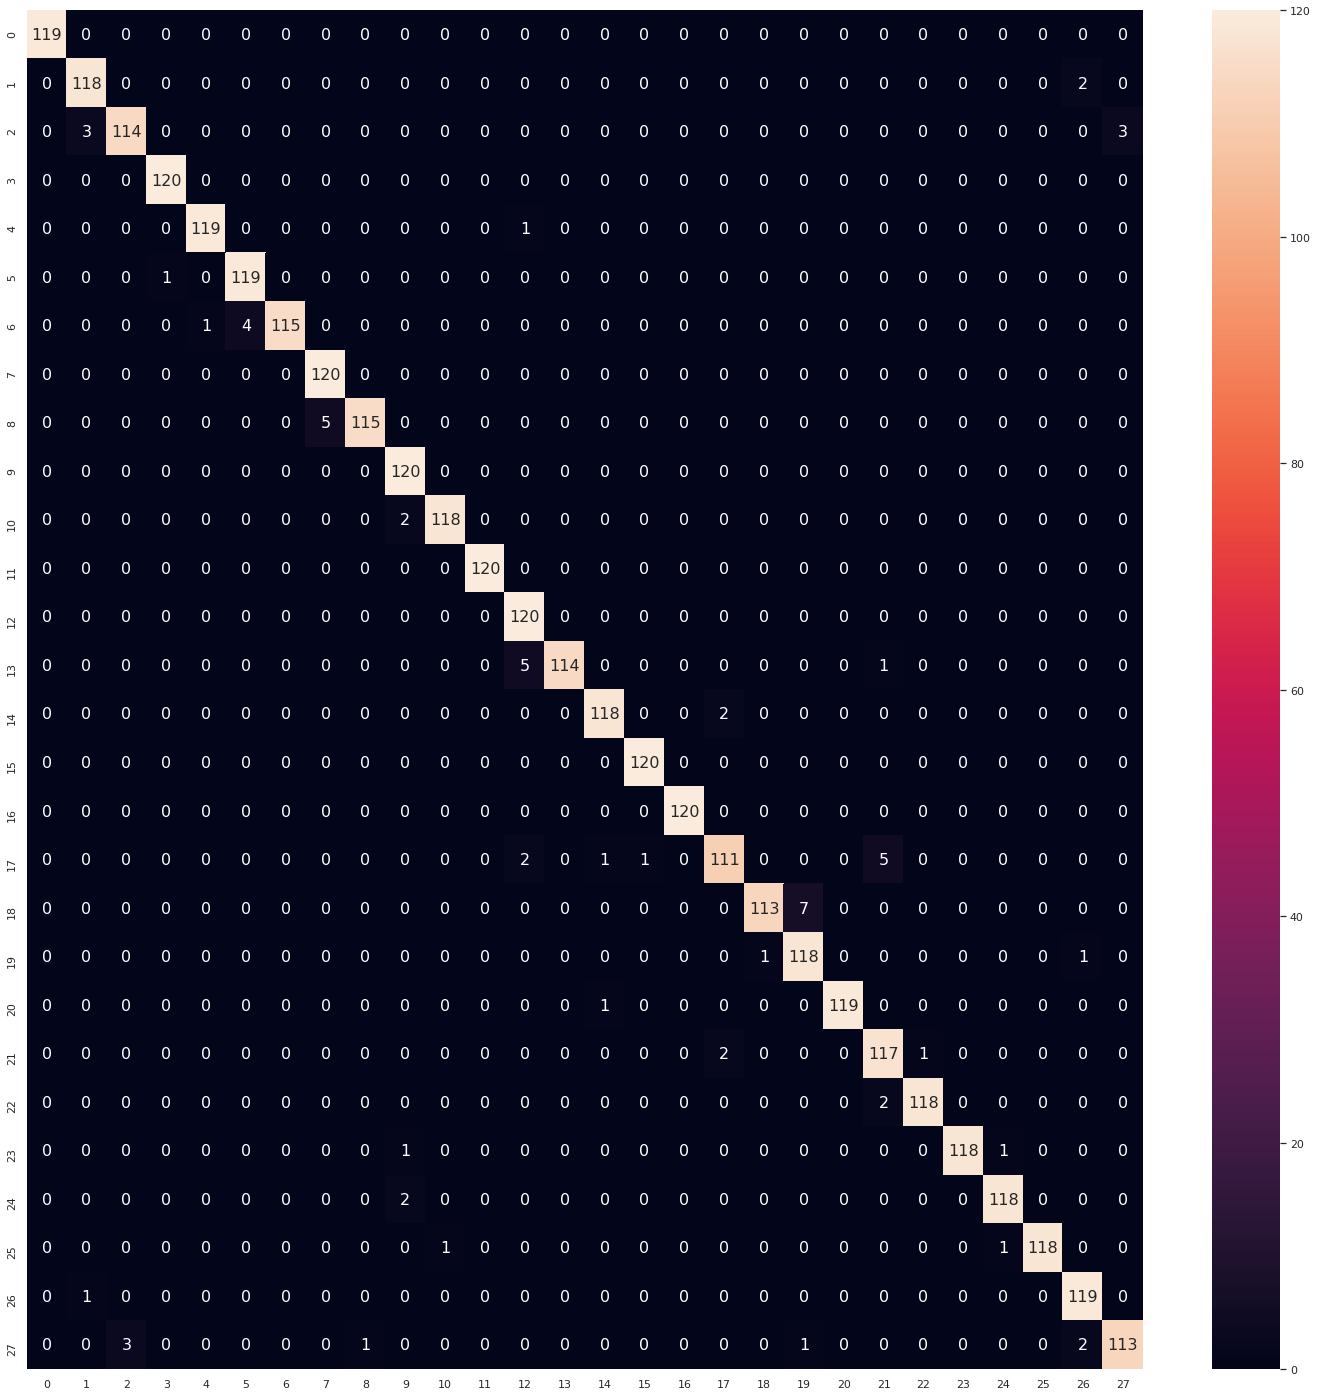

<Figure size 1080x1080 with 0 Axes>

,Precision,Recall,F1_score
0,1.000000,1.000000,1.000000
1,0.967213,0.983333,0.975207
2,0.974359,0.950000,0.962025
3,0.991736,1.000000,0.995851
4,0.991667,0.991667,0.991667
5,0.967480,0.991667,0.979424
6,1.000000,0.958333,0.978723
7,0.960000,1.000000,0.979592
8,0.991379,0.958333,0.974576
9,0.960000,1.000000,0.979592


In [0]:
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.math import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = test_gen.flow_from_directory('/content/datasets/test',
                                                 target_size=(32, 32),
                                                 batch_size=1,
                                                  shuffle=False,
                                                 class_mode = 'categorical'                                              
                                                 )
probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities.argmax(axis=1)

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(28), range(28))
sn.set(font_scale=1.4) # for label size
sn.set(rc={'figure.figsize':(25,25)})
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt= 'd') # font size
plt.figure(figsize = (15,15))
plt.show()

precision, recall, f1, _ = score(y_true, y_pred)
pd.DataFrame([precision, recall, f1] , index = ['Precision', 'Recall', 'F1_score']).T
# 97.97% accuracy on test


In [0]:
mat.diagonal().sum()/3359

0.979755879726109

# showing some predictions

In [0]:
test_generator.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '14': 5,
 '15': 6,
 '16': 7,
 '17': 8,
 '18': 9,
 '19': 10,
 '2': 11,
 '20': 12,
 '21': 13,
 '22': 14,
 '23': 15,
 '24': 16,
 '25': 17,
 '26': 18,
 '27': 19,
 '28': 20,
 '3': 21,
 '4': 22,
 '5': 23,
 '6': 24,
 '7': 25,
 '8': 26,
 '9': 27}

In [0]:
{str(idx):int(classes) for classes,idx in test_generator.class_indices.items()}

{'0': 1,
 '1': 10,
 '10': 19,
 '11': 2,
 '12': 20,
 '13': 21,
 '14': 22,
 '15': 23,
 '16': 24,
 '17': 25,
 '18': 26,
 '19': 27,
 '2': 11,
 '20': 28,
 '21': 3,
 '22': 4,
 '23': 5,
 '24': 6,
 '25': 7,
 '26': 8,
 '27': 9,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 '9': 18}

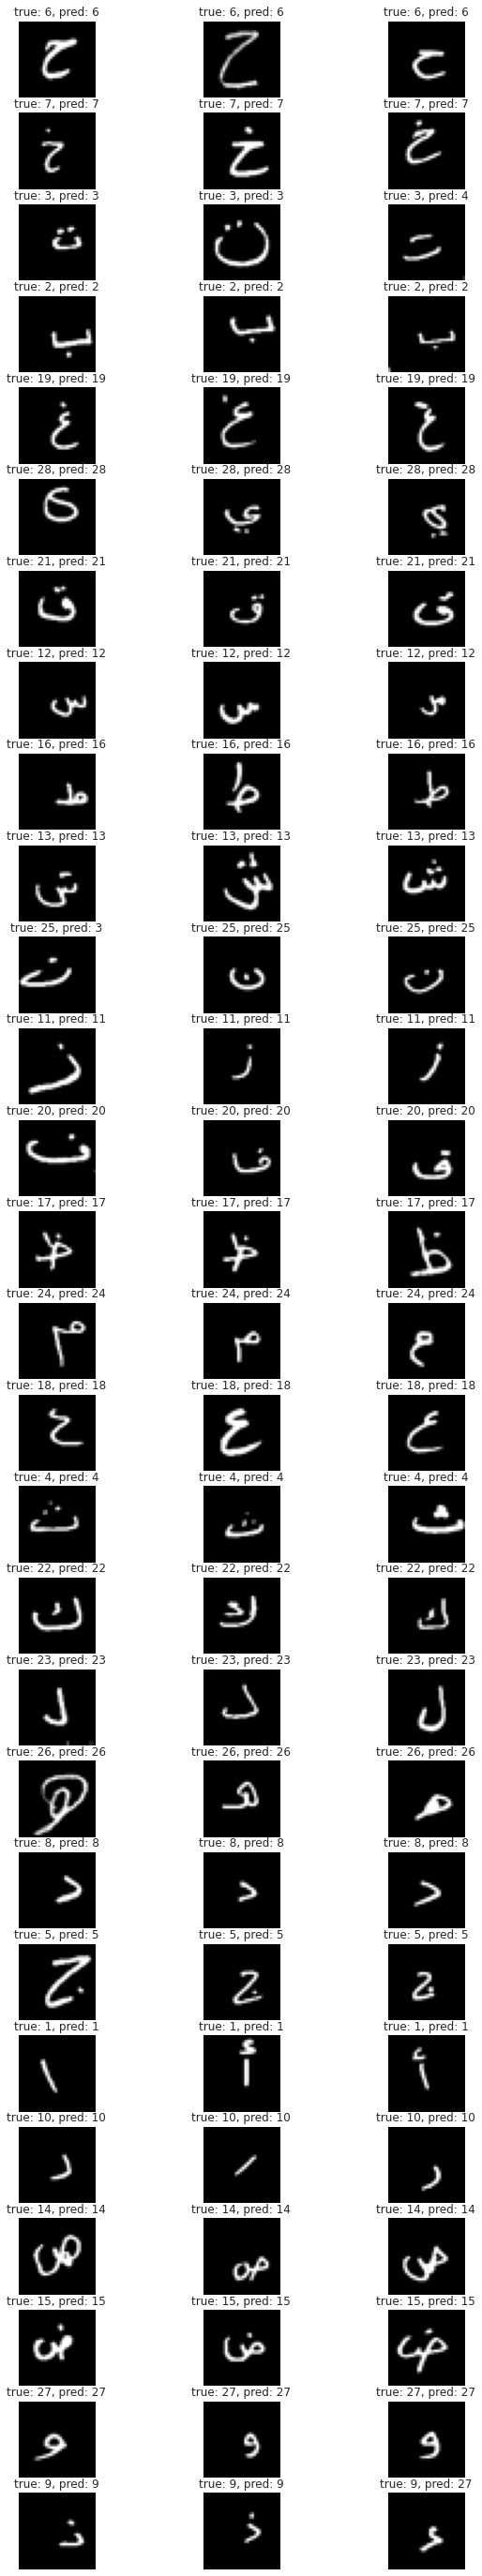

In [0]:
import os
import matplotlib.pyplot as plt

classes = os.listdir('/content/datasets/test')
idx_class = {str(idx):int(classes) for classes,idx in test_generator.class_indices.items()}
i = 0
plt.figure(figsize=(10,50))
for c in classes:
  imgs = os.listdir('/content/datasets/test/'+c)
  num_files = 0
  for img in imgs:
    plt.subplot(28,3,i+1)
    imga = image.img_to_array(image.load_img('/content/datasets/test/' + c + '/' + img))
    imga_normalized = imga/255.
    imga_add = np.expand_dims(imga_normalized, axis=0)
    
    pred = model.predict(imga_add).argmax(axis = 1)
    plt.grid(b=None)
    plt.axis('off')
    plt.imshow(imga_add[0])
    plt.title('true: {}, pred: {}'.format(c, idx_class[str(pred[0])]))
    
    i+=1
    num_files+=1
    if num_files == 3:
      break

